<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/Assignment3Test2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python --version

Python 3.7.12


# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [1]:
#@title Some utils
from random import randint
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, ):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size=1)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [2]:
# @title build_attention_model function <- old-delete

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [3]:
# @title build_attention_model function

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

## LuongDotAttention

Luong Dot Attention score is defined by:

$$score(h_t,\hat{h}_s)= h_t^T \hat{h}_s$$

Notice that this attention function don't have training paramaters.


In [4]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Defining parameters

In [5]:
#@title changed part n_timesteps_in, n_features
# dataset 
n_timesteps_in = 4  # Sequence length                                                 ## changed from 100 to 4
n_features = 10     # Maximum number allowed-1 (length of the one-hot-encoded vector) ## changed from 20 to 10
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features)

# training parameters
batch_size = 1

# model parameters
rnn_units = 16       # changed from 100 to 16

## Attention model - Luong Dot

In [9]:
# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense  = build_attention_model(attention, batch_size, rnn_units) 
# we need this encoder/decoder for the weight representation

### Training model

Epoch 1/5
1800/1800 [==============================] - 53s 16ms/step - loss: 1.6434 - accuracy: 0.3699 - val_loss: 1.3592 - val_accuracy: 0.4200
Epoch 2/5
1800/1800 [==============================] - 26s 15ms/step - loss: 1.2689 - accuracy: 0.4556 - val_loss: 1.1534 - val_accuracy: 0.5000
Epoch 3/5
1800/1800 [==============================] - 27s 15ms/step - loss: 0.9899 - accuracy: 0.5967 - val_loss: 0.7914 - val_accuracy: 0.7312
Epoch 4/5
1800/1800 [==============================] - 27s 15ms/step - loss: 0.5491 - accuracy: 0.8301 - val_loss: 0.2904 - val_accuracy: 0.9500
Epoch 5/5
200/200 [==============================] - 2s 8ms/step - loss: 0.1144 - accuracy: 0.9925

PREDICTION ACCURACY (%):
Train: 98.838, Test: 99.250


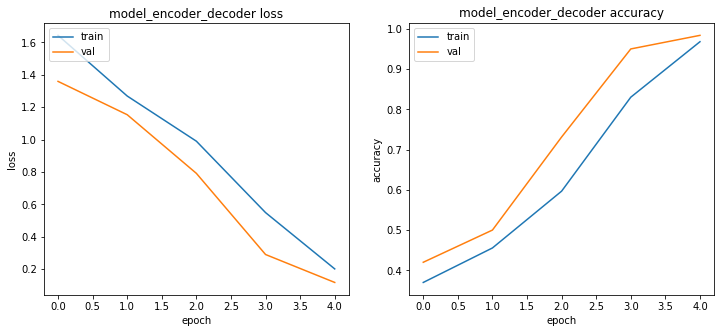

In [10]:
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=5, patience=3)

### Prediction

In [11]:
Xtest = one_hot_encode(np.array([1,2,3,4]), n_features)
predict(model_attention, n_timesteps_in, n_features, Xtest)

input [1, 2, 3, 4]
predicted [4, 3, 1, 1]


In [ ]:
one_hot_decode(X_test[0])

[1, 8, 1, 5]

In [ ]:
predict(model_attention, n_timesteps_in, n_features, X_test[0])

input [1, 8, 1, 5]
predicted [5, 1, 8, 1]


In [ ]:
predict(model_attention, n_timesteps_in, n_features, X_test[1])

input [4, 9, 7, 7]
predicted [7, 7, 9, 4]


### Visualization the Weight

#### function to Plot Weight

The idea is take the `build_function` and modify in order to get the `attention_weightPlot` and the `input_seq` and `out_seq`. For do that we need to take into account the following from our model:
* `attention`: the Attention function (LuongDot, LuongGeneral, Bahdanau).
* `encoder_lstm`: encoder used
* `decoder_lstm`: decoder used
* `decoder_dense`: decoder used

In [13]:
 #@title function to Compute and Plot the weight
# function to Compute and Plot the weight

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



def build_attention_weight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    #encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    #encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
    sequence = one_hot_encode(seq_in,n_features)

    encoder_inputs=np.array(sequence).reshape(1,n_timesteps_in,n_features)
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)

    # Def encoder_lstm
    #encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm') <--------- Usamos los entrenados
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    #decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')        # <--------- Usamos los entrenados
    #decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense') # <--------- Usamos los entrenados
    decoder_input_data = np.zeros((1, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = decoder_input_data
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for i in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states) <---------
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()
        #context_vector = tf.expand_dims(context_vector, 1) <---------

        decoder_outputs=tf.expand_dims(decoder_outputs, 1)

        context_vector = tf.expand_dims(context_vector, 1)


        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)      
        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])  # <---------

    
    #model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')  <---------
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) <---------
    
    return seq_in, seq_out, attention_plot

### Plot attention function

In [14]:
from matplotlib import ticker

def plot_attention(attention, sequence, predicted_sequence):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sequence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def plotWeight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
  seq_in, seq_out, attention_plot = build_attention_weight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense)

  print('Input: %s' % (seq_in))
  print('Predicted translation: {}'.format(seq_out))

  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out)

lo hace fatal!! porque? no esta cogiendo el encoder decoder trained. ni los attention weight antes encontrados.

Input: [9, 2, 3, 4]
Predicted translation: [4, 3, 2, 9]


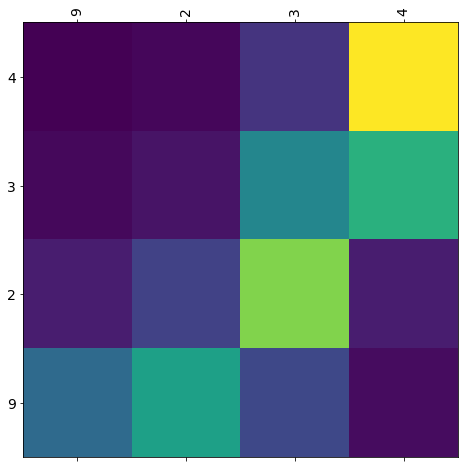

In [15]:
plotWeight([9,2,3,4], attention, encoder_lstm, decoder_lstm, decoder_dense)

Input: [1, 2, 3, 4]
Predicted translation: [4, 3, 1, 1]


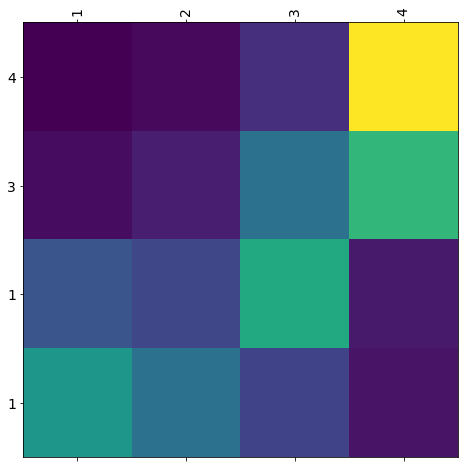

In [18]:
plotWeight([1,2,3,4], attention, encoder_lstm, decoder_lstm, decoder_dense)

# BahdanauAttention

Bahdanau attention function is defined by:

$$ score(h_t, \hat{h}_s)=V^Ttanh(W_a[h_t:\hat{h}_s])$$

In [26]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
# attention model
attentionBahdanauAttention = BahdanauAttention(16)
model_attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah = build_attention_model(attentionBahdanauAttention, batch_size, rnn_units)

Epoch 1/2
1800/1800 [==============================] - 42s 18ms/step - loss: 1.6644 - accuracy: 0.3565 - val_loss: 1.3431 - val_accuracy: 0.4338
Epoch 2/2
200/200 [==============================] - 1s 7ms/step - loss: 0.8149 - accuracy: 0.7300

PREDICTION ACCURACY (%):
Train: 74.562, Test: 73.000


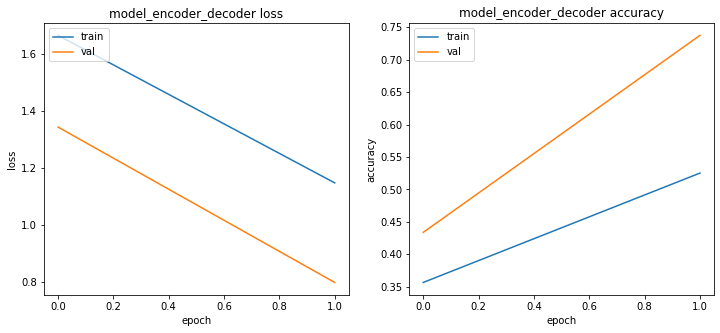

In [28]:
train_test(model_attentionBahdanauAttention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=2, patience=3)

In [29]:
predict(model_attentionBahdanauAttention, n_timesteps_in, n_features, X_test[0])

input [9, 5, 2, 8]
predicted [8, 2, 5, 9]


In [ ]:
predict(model_attentionBahdanauAttention, n_timesteps_in, n_features, X_test[1])

input [4, 9, 7, 7]
predicted [7, 7, 9, 4]


Input: [9, 5, 2, 8]
Predicted translation: [8, 2, 5, 9]


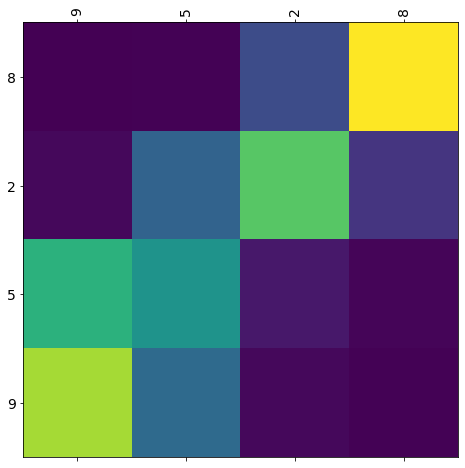

In [31]:
plotWeight([9, 5, 2, 8], attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah)

Input: [1, 8, 1, 5]
Predicted translation: [1, 1, 1, 1]


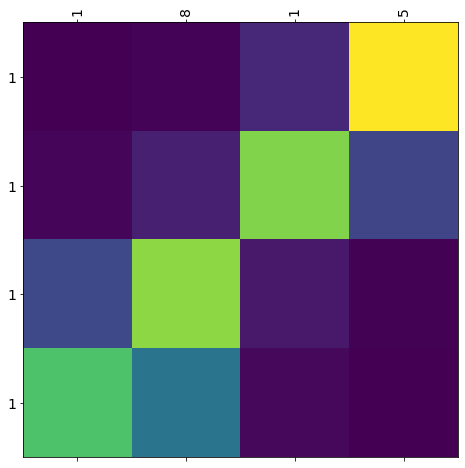

In [33]:
plotWeight([1, 8, 1, 5], attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah)

# LuongGeneralAttention

Luong General Attention function is defined by:

$$score(h_t,\hat{h}_s)= h_t^T W_a\hat{h}_s$$


In [34]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       self.W1(values_transposed)), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Epoch 1/5
1800/1800 [==============================] - 36s 16ms/step - loss: 1.5732 - accuracy: 0.3651 - val_loss: 1.2929 - val_accuracy: 0.4363
Epoch 2/5
1800/1800 [==============================] - 27s 15ms/step - loss: 1.1936 - accuracy: 0.4769 - val_loss: 1.0479 - val_accuracy: 0.5475
Epoch 3/5
1800/1800 [==============================] - 26s 15ms/step - loss: 0.9437 - accuracy: 0.6089 - val_loss: 0.7989 - val_accuracy: 0.6925
Epoch 4/5
1800/1800 [==============================] - 28s 16ms/step - loss: 0.6734 - accuracy: 0.7369 - val_loss: 0.5217 - val_accuracy: 0.8075
Epoch 5/5
200/200 [==============================] - 3s 13ms/step - loss: 0.2939 - accuracy: 0.9087

PREDICTION ACCURACY (%):
Train: 93.237, Test: 90.875


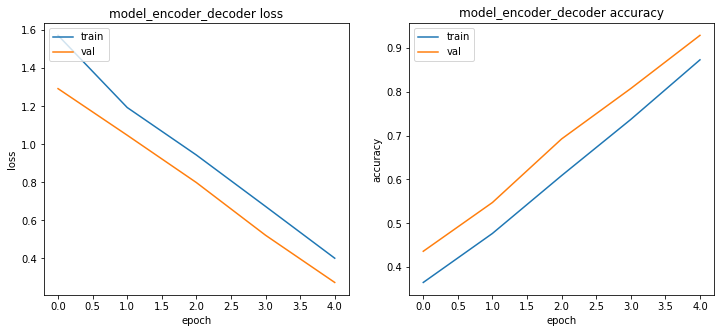

In [35]:
# attention model
attentionLuongGeneral = LuongGeneralAttention(units = 1)
model_attentionLuongGeneral, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen = build_attention_model(attentionLuongGeneral, batch_size, rnn_units)


#training
train_test(model_attentionLuongGeneral, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=5, patience=3)

Esto funciona teniendo:
Dataset formado por 
- n_timesteps_in = 100
- n_features = 20
- batch_size = 100
- rnn_units = 100

**El tema esta en tenir la mateixa rnn_units i batch_size**

# vamos a probar de predecir
a priori no deberia funcionar debido al batch_size

In [36]:
predict(model_attentionLuongGeneral, n_timesteps_in, n_features, one_hot_encode([1,2,3,4], 10))

input [1, 2, 3, 4]
predicted [4, 3, 2, 1]


In [ ]:
predict(model_attentionLuongGeneral, n_timesteps_in, n_features, X_test[0])

input [6, 5, 8, 1]
predicted [1, 8, 5, 6]


# Visualize the weight

Input: [1, 2, 3, 4]
Predicted translation: [4, 6, 2, 1]


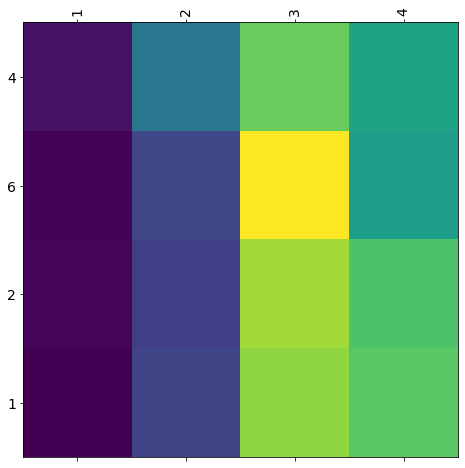

In [37]:
plotWeight([1, 2, 3, 4], attentionBahdanauAttention, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen)

Input: [1, 8, 1, 5]
Predicted translation: [5, 1, 1, 1]


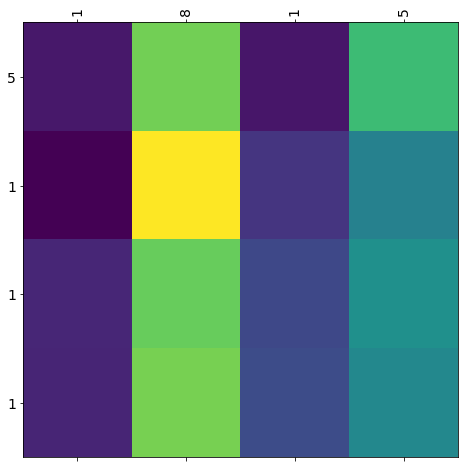

In [38]:
plotWeight([1, 8, 1, 5], attentionBahdanauAttention, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen)